# COVID19 - District Region

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
LoadData=False

if LoadData:
    get_data.get_data()

In [3]:
dfSP = pd.read_csv("data/dados_municipios_SP.csv")
dfSP

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,DRS
0,2020-04-19,SP,TOTAL,state,14267,1015,53,True,45919049.0,35.0,31.06989,0.0711,Indefinido
1,2020-04-18,SP,TOTAL,state,13894,991,52,False,45919049.0,35.0,30.25760,0.0713,Indefinido
2,2020-04-17,SP,TOTAL,state,12841,928,51,False,45919049.0,35.0,27.96443,0.0723,Indefinido
3,2020-04-16,SP,TOTAL,state,11568,853,50,False,45919049.0,35.0,25.19216,0.0737,Indefinido
4,2020-04-15,SP,TOTAL,state,11043,778,49,False,45919049.0,35.0,24.04884,0.0705,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2020-04-14,SP,Águas de São Pedro,city,1,0,5,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3264,2020-04-13,SP,Águas de São Pedro,city,1,0,4,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3265,2020-04-12,SP,Águas de São Pedro,city,1,0,3,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3266,2020-04-11,SP,Águas de São Pedro,city,1,0,2,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba


In [4]:
# Model

In [5]:
# lista DRSs
DRS = list(dfSP["DRS"].unique())
DRS.remove("Indefinido")
DRS

['DRS 09 - Marília',
 'DRS 06 - Bauru',
 'DRS 16 - Sorocaba',
 'DRS 07 - Campinas',
 'DRS 03 - Araraquara',
 'DRS 02 - Araçatuba',
 'DRS 17 - Taubaté',
 'DRS 10 - Piracicaba',
 'DRS 01 - Grande São Paulo',
 'DRS 15 - São José do Rio Preto',
 'DRS 12 - Registro',
 'DRS 05 - Barretos',
 'DRS 13 - Ribeirão Preto',
 'DRS 11 - Presidente Prudente',
 'DRS 04 - Baixada Santista',
 'DRS 14 - São João da Boa Vista',
 'DRS 08 - Franca']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [6]:
#objective function Odeint solver
from scipy.integrate import odeint

#objective function Odeint solver
def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b, mu = point
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S+mu*S #S
        y1=(beta2*A+beta*I)*S-sigma*E-mu*E #E
        y2=sigma*E*(1-p)-gamma*A-mu*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I-mu*I#I
        y4=b*I+gamma*A+sigma2*I-mu*R #R
        y5=(-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SEAIRD,y0,tspan,hmax=0.01)

    l1=0
    l2=0
    l3=0
    tot=0

    for i in range(0,len(data.values)):
        if data.values[i]>startNCases:
            l1 = l1+(res[i,3] - data.values[i])**2
            l2 = l2+(res[i,5] - death.values[i])**2
            newRecovered=min(1e6,data.values[i]*ratioRecovered)
            l3 = l3+(res[i,4] - newRecovered)**2
            tot+=1
    l1=np.sqrt(l1/max(1,tot))
    l2=np.sqrt(l2/max(1,tot))
    l3=np.sqrt(l3/max(1,tot))
    
    #weight for cases
    u = weigthCases  #Brazil US 0.1
    w = weigthRecov
    #weight for deaths
    v = max(0,1. - u - w)
    
    return u*l1 + v*l2 + w*l3

In [7]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-15,60,280000.0,0.0001,0.0001,0.0001,0.0001,80.0000,1500,0.1,0.6,0.1
1,DRS 02 - Araçatuba,2020-04-01,60,500.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
2,DRS 03 - Araraquara,2020-04-01,60,2000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
3,DRS 04 - Baixada Santista,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
4,DRS 05 - Barretos,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
5,DRS 06 - Bauru,2020-04-01,60,10000.0,0.0001,0.0001,4.0000,0.0001,0.0001,0,0.1,0.4,0.1
6,DRS 07 - Campinas,2020-04-01,60,20000.0,0.0001,0.0001,40.0000,0.0001,0.0001,0,0.1,0.4,0.1
7,DRS 08 - Franca,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
8,DRS 09 - Marília,2020-04-01,60,5000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
9,DRS 10 - Piracicaba,2020-04-01,60,10000.0,0.0001,0.0001,0.0001,0.0001,1.0000,0,0.1,0.4,0.1


In [8]:
# Initial parameter optimization

In [11]:
# Load solver
GlobalOptimization=True
import ray

if GlobalOptimization:
    import ray
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
else:
    import Learner #minimize

2020-04-22 18:32:06,750	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-04-22 18:32:06,751	INFO resource_spec.py:205 -- Starting Ray with 130.13 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-22 18:32:06,982	WARNING services.py:770 -- Redis failed to start, retrying now.


In [12]:
allDistricts=True

results=[]
if allDistricts:
    for districtRegion in DRS:
        query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        learner = Learner.Learner.remote(districtRegion, lossOdeint, *parameters)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    districtRegion="DRS 01 - Grande São Paulo"
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
    learner.train()

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

(pid=58427) 
(pid=58427)  running model for DRS 17 - Taubaté
(pid=58430) 
(pid=58430)  running model for DRS 07 - Campinas
(pid=58431) 
(pid=58431)  running model for DRS 02 - Araçatuba
(pid=58415) 
(pid=58415)  running model for DRS 03 - Araraquara
(pid=58417) 
(pid=58417)  running model for DRS 16 - Sorocaba
(pid=58419) 
(pid=58419)  running model for DRS 06 - Bauru
(pid=58421) 
(pid=58421)  running model for DRS 09 - Marília
(pid=58418) 
(pid=58418)  running model for DRS 05 - Barretos
(pid=58423) 
(pid=58423)  running model for DRS 11 - Presidente Prudente
(pid=58432) 
(pid=58432)  running model for DRS 04 - Baixada Santista
(pid=58420) 
(pid=58420)  running model for DRS 12 - Registro
(pid=58433) 
(pid=58433)  running model for DRS 10 - Piracicaba
(pid=58429) 
(pid=58429)  running model for DRS 01 - Grande São Paulo
(pid=58422) 
(pid=58422)  running model for DRS 15 - São José do Rio Preto
(pid=58425) 
(pid=58425)  running model for DRS 14 - São João da Boa Vista
(pid=58414) 
(pid

(pid=58429) basinhopping step 5: f 347.457 trial_f 4684.38 accepted 0  lowest_f 347.457
(pid=58429) /home/ats4i/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=58429)   warnings.warn(warning_msg, ODEintWarning)
(pid=58427) basinhopping step 1: f 5.5051 trial_f 5.5051 accepted 1  lowest_f 5.49798
(pid=58432) basinhopping step 6: f 18.9055 trial_f 101.31 accepted 0  lowest_f 18.9005
(pid=58422) basinhopping step 2: f 3.05409 trial_f 3.05409 accepted 1  lowest_f 2.75891
(pid=58429) warning: basinhopping: local minimization failure
(pid=58429) basinhopping step 6: f 347.457 trial_f 4684.4 accepted 0  lowest_f 347.457
(pid=58420) warning: basinhopping: local minimization failure
(pid=58420) basinhopping step 3: f 1.56437 trial_f 6.4497 accepted 0  lowest_f 1.56437
(pid=58431) basinhopping step 4: f 3.07156 trial_f 3.07156 accepted 1  lo

(pid=58422) basinhopping step 5: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58421) basinhopping step 6: f 1.32668 trial_f 1.32668 accepted 1  lowest_f 1.32668
(pid=58421) found new global minimum on step 6 with function value 1.32668
(pid=58415) basinhopping step 7: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58415) found new global minimum on step 7 with function value 3.07041
(pid=58417) basinhopping step 7: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58418) basinhopping step 13: f 2.50141 trial_f 4.15219 accepted 0  lowest_f 1.0816
(pid=58433) basinhopping step 6: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=58429) basinhopping step 7: f 347.412 trial_f 347.412 accepted 1  lowest_f 347.412
(pid=58429) found new global minimum on step 7 with function value 347.412
(pid=58419) basinhopping step 11: f 4.89315 trial_f 27.0546 accepted 0  lowest_f 4.89315
(pid=58423) basinhopping step 7: f 1.98192 trial_f 1.98192 accepted 1 

(pid=58415) basinhopping step 11: f 3.28765 trial_f 3.28765 accepted 1  lowest_f 3.07041
(pid=58423) basinhopping step 11: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58415) basinhopping step 12: f 3.28765 trial_f 12.176 accepted 0  lowest_f 3.07041
(pid=58418) basinhopping step 19: f 2.24982 trial_f 2.24982 accepted 1  lowest_f 1.0816
(pid=58421) basinhopping step 12: f 1.33377 trial_f 1.33377 accepted 1  lowest_f 1.32645
(pid=58430) basinhopping step 12: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=58417) basinhopping step 11: f 5.50812 trial_f 5.50812 accepted 1  lowest_f 4.03596
(pid=58422) basinhopping step 9: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58427) basinhopping step 8: f 5.4979 trial_f 5.4979 accepted 1  lowest_f 5.4979
(pid=58427) found new global minimum on step 8 with function value 5.4979
(pid=58420) basinhopping step 12: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58419) basinhopping step 13: f 4.89315

(pid=58424) basinhopping step 21: f 6.44474 trial_f 29.4739 accepted 0  lowest_f 6.44474
(pid=58427) basinhopping step 11: f 5.4979 trial_f 44.8868 accepted 0  lowest_f 5.4979
(pid=58417) basinhopping step 15: f 4.03596 trial_f 20.164 accepted 0  lowest_f 4.03596
(pid=58423) basinhopping step 15: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58423) found new global minimum on step 15 with function value 1.98192
(pid=58429) basinhopping step 15: f 347.443 trial_f 707.277 accepted 0  lowest_f 347.412
(pid=58419) basinhopping step 22: f 4.89315 trial_f 26.764 accepted 0  lowest_f 4.89315
(pid=58415) basinhopping step 15: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58418) basinhopping step 24: f 1.08162 trial_f 1.08162 accepted 1  lowest_f 1.0816
(pid=58425) basinhopping step 11: f 1.5614 trial_f 1.5614 accepted 1  lowest_f 1.5614
(pid=58431) basinhopping step 18: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58420) basinhopping step 21: f 1.5643

(pid=58432) basinhopping step 22: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=58420) basinhopping step 25: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58430) basinhopping step 20: f 13.3336 trial_f 13.3336 accepted 1  lowest_f 11.0947
(pid=58424) basinhopping step 25: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58420) warning: basinhopping: local minimization failure
(pid=58420) basinhopping step 26: f 1.56437 trial_f 6.4497 accepted 0  lowest_f 1.56437
(pid=58431) basinhopping step 24: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58433) basinhopping step 19: f 3.03218 trial_f 13.6479 accepted 0  lowest_f 3.03218
(pid=58414) basinhopping step 17: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=58418) basinhopping step 28: f 1.08162 trial_f 1.08162 accepted 1  lowest_f 1.0816
(pid=58418) basinhopping step 29: f 1.08162 trial_f 4.49005 accepted 0  lowest_f 1.0816
(pid=58418) basinhopping step 30: f 1.08162 trial_f

(pid=58431) basinhopping step 28: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58423) basinhopping step 26: f 1.98192 trial_f 6.57394 accepted 0  lowest_f 1.98192
(pid=58433) basinhopping step 23: f 3.03218 trial_f 14.008 accepted 0  lowest_f 3.03218
(pid=58421) basinhopping step 23: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58433) basinhopping step 24: f 3.03218 trial_f 14.8651 accepted 0  lowest_f 3.03218
(pid=58423) warning: basinhopping: local minimization failure
(pid=58423) basinhopping step 27: f 1.98192 trial_f 7.10246 accepted 0  lowest_f 1.98192
(pid=58432) basinhopping step 26: f 18.9005 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=58427) basinhopping step 19: f 5.52515 trial_f 5.52515 accepted 1  lowest_f 5.4979
(pid=58429) basinhopping step 25: f 347.408 trial_f 920.644 accepted 0  lowest_f 347.408
(pid=58431) basinhopping step 29: f 3.07182 trial_f 3.07182 accepted 1  lowest_f 3.07156
(pid=58422) basinhopping step 22: f 2.75891 trial_

(pid=58417) basinhopping step 29: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58423) basinhopping step 32: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58430) basinhopping step 26: f 11.4279 trial_f 11.4279 accepted 1  lowest_f 11.0947
(pid=58415) basinhopping step 26: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58418) basinhopping step 41: f 1.2465 trial_f 1.2465 accepted 1  lowest_f 1.0816
(pid=58415) basinhopping step 27: f 3.07041 trial_f 13.7625 accepted 0  lowest_f 3.07041
(pid=58432) basinhopping step 32: f 18.9035 trial_f 18.9035 accepted 1  lowest_f 18.9004
(pid=58429) basinhopping step 28: f 347.408 trial_f 2666.24 accepted 0  lowest_f 347.408
(pid=58431) basinhopping step 35: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58418) basinhopping step 42: f 1.2465 trial_f 4.05174 accepted 0  lowest_f 1.0816
(pid=58420) basinhopping step 36: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58414) basinhopping s

(pid=58422) basinhopping step 31: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58431) basinhopping step 40: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58419) basinhopping step 35: f 4.89315 trial_f 24.4196 accepted 0  lowest_f 4.89315
(pid=58422) basinhopping step 32: f 2.75891 trial_f 30.2479 accepted 0  lowest_f 2.75891
(pid=58417) basinhopping step 33: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58417) found new global minimum on step 33 with function value 4.03596
(pid=58422) basinhopping step 33: f 2.75891 trial_f 27.6012 accepted 0  lowest_f 2.75891
(pid=58419) basinhopping step 36: f 4.89315 trial_f 26.5197 accepted 0  lowest_f 4.89315
(pid=58430) basinhopping step 30: f 11.4279 trial_f 87.6202 accepted 0  lowest_f 11.0947
(pid=58421) basinhopping step 30: f 1.32651 trial_f 1.32651 accepted 1  lowest_f 1.32645
(pid=58422) basinhopping step 34: f 2.75891 trial_f 22.9019 accepted 0  lowest_f 2.75891
(pid=58418) basinhopping step 47: 

(pid=58417) basinhopping step 37: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58417) found new global minimum on step 37 with function value 4.03596
(pid=58423) basinhopping step 39: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58418) basinhopping step 56: f 1.08161 trial_f 4.49008 accepted 0  lowest_f 1.0816
(pid=58418) basinhopping step 57: f 4.49005 trial_f 4.49005 accepted 1  lowest_f 1.0816
(pid=58431) basinhopping step 45: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58420) basinhopping step 45: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58427) basinhopping step 33: f 5.51229 trial_f 13.0807 accepted 0  lowest_f 5.4979
(pid=58421) basinhopping step 32: f 1.32708 trial_f 1.32708 accepted 1  lowest_f 1.32645
(pid=58417) basinhopping step 38: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58422) basinhopping step 39: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58433) basinhopping step 38: f 3

(pid=58419) basinhopping step 45: f 4.89315 trial_f 25.9574 accepted 0  lowest_f 4.89315
(pid=58430) basinhopping step 38: f 11.0947 trial_f 17.3858 accepted 0  lowest_f 11.0947
(pid=58431) basinhopping step 51: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58420) basinhopping step 49: f 1.56437 trial_f 5.00857 accepted 0  lowest_f 1.56437
(pid=58420) adaptive stepsize: acceptance rate 0.620000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
(pid=58427) basinhopping step 35: f 5.4979 trial_f 5.4979 accepted 1  lowest_f 5.4979
(pid=58432) basinhopping step 49: f 18.9023 trial_f 18.9023 accepted 1  lowest_f 18.9004
(pid=58432) adaptive stepsize: acceptance rate 0.580000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
(pid=58418) basinhopping step 63: f 1.0816 trial_f 1.0816 accepted 1  lowest_f 1.0816
(pid=58420) basinhopping step 50: f 6.05044 trial_f 6.05044 accepted 1  lowest_f 1.56437
(pid=58414) basinhopping step 40: f 1.17754 trial_f 1.17754 accepted 1  

(pid=58432) basinhopping step 53: f 18.9055 trial_f 18.9055 accepted 1  lowest_f 18.9004
(pid=58431) basinhopping step 55: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58421) basinhopping step 40: f 1.32661 trial_f 6.11667 accepted 0  lowest_f 1.32645
(pid=58414) basinhopping step 43: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=58432) basinhopping step 54: f 18.9055 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=58418) basinhopping step 68: f 1.80005 trial_f 4.19152 accepted 0  lowest_f 1.0816
(pid=58423) basinhopping step 48: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58425) basinhopping step 33: f 1.56305 trial_f 1.56305 accepted 1  lowest_f 1.5614
(pid=58432) warning: basinhopping: local minimization failure
(pid=58432) basinhopping step 55: f 18.9055 trial_f 107.036 accepted 0  lowest_f 18.9004
(pid=58422) basinhopping step 46: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58414) basinhopping step 44: f 1.17754 trial_

(pid=58414) basinhopping step 51: f 1.17754 trial_f 3.40504 accepted 0  lowest_f 1.17754
(pid=58415) basinhopping step 49: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58415) adaptive stepsize: acceptance rate 0.700000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
(pid=58419) basinhopping step 52: f 4.89315 trial_f 27.2592 accepted 0  lowest_f 4.89315
(pid=58422) basinhopping step 52: f 2.75935 trial_f 2.75935 accepted 1  lowest_f 2.75891
(pid=58420) basinhopping step 57: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58421) basinhopping step 43: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58432) basinhopping step 57: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=58423) basinhopping step 51: f 1.98192 trial_f 5.4313 accepted 0  lowest_f 1.98192
(pid=58424) basinhopping step 61: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58425) basinhopping step 36: f 1.56298 trial_f 5.5425 accepted 0  lowest_f 1.5614
(p

(pid=58422) basinhopping step 55: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58419) basinhopping step 55: f 5.75589 trial_f 5.75589 accepted 1  lowest_f 4.89315
(pid=58414) basinhopping step 55: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=58425) basinhopping step 39: f 1.56362 trial_f 1.56362 accepted 1  lowest_f 1.5614
(pid=58420) basinhopping step 60: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58418) basinhopping step 79: f 1.08164 trial_f 1.08164 accepted 1  lowest_f 1.0816
(pid=58417) basinhopping step 55: f 4.03596 trial_f 23.9012 accepted 0  lowest_f 4.03596
(pid=58430) basinhopping step 51: f 11.0947 trial_f 17.3439 accepted 0  lowest_f 11.0947
(pid=58419) basinhopping step 56: f 5.75589 trial_f 27.0749 accepted 0  lowest_f 4.89315
(pid=58423) basinhopping step 56: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58418) warning: basinhopping: local minimization failure
(pid=58418) basinhopping step 80: f 1.08164 trial_

(pid=58414) basinhopping step 61: f 2.95823 trial_f 2.95823 accepted 1  lowest_f 1.17754
(pid=58418) basinhopping step 88: f 1.0816 trial_f 1.0816 accepted 1  lowest_f 1.0816
(pid=58418) basinhopping step 89: f 1.0816 trial_f 4.49005 accepted 0  lowest_f 1.0816
(pid=58424) basinhopping step 72: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58419) basinhopping step 59: f 4.89315 trial_f 8.3017 accepted 0  lowest_f 4.89315
(pid=58424) basinhopping step 73: f 6.44474 trial_f 31.2513 accepted 0  lowest_f 6.44474
(pid=58422) basinhopping step 60: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58417) basinhopping step 58: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58430) basinhopping step 55: f 11.0947 trial_f 25.5782 accepted 0  lowest_f 11.0947
(pid=58414) basinhopping step 62: f 1.18403 trial_f 1.18403 accepted 1  lowest_f 1.17754
(pid=58415) basinhopping step 61: f 3.07213 trial_f 3.07213 accepted 1  lowest_f 3.07041
(pid=58425) basinhopping st

(pid=58431) basinhopping step 75: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58418) basinhopping step 95: f 1.08164 trial_f 1.08164 accepted 1  lowest_f 1.0816
(pid=58432) basinhopping step 68: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=58422) basinhopping step 65: f 2.75993 trial_f 2.75993 accepted 1  lowest_f 2.75891
(pid=58432) basinhopping step 69: f 18.9004 trial_f 100.05 accepted 0  lowest_f 18.9004
(pid=58425) basinhopping step 45: f 1.56298 trial_f 1.56298 accepted 1  lowest_f 1.5614
(pid=58417) basinhopping step 62: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58424) basinhopping step 77: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58427) basinhopping step 52: f 5.52515 trial_f 5.52515 accepted 1  lowest_f 5.4979
(pid=58430) basinhopping step 59: f 11.0947 trial_f 17.2865 accepted 0  lowest_f 11.0947
(pid=58431) basinhopping step 76: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58432) basinhopping 

(pid=58433) basinhopping step 67: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=58419) basinhopping step 68: f 5.80875 trial_f 27.0749 accepted 0  lowest_f 4.89315
(pid=58429) basinhopping step 59: f 347.443 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58432) basinhopping step 74: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=58429) basinhopping step 60: f 347.443 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58427) basinhopping step 56: f 5.49961 trial_f 5.49961 accepted 1  lowest_f 5.4979
(pid=58429) basinhopping step 61: f 347.443 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58424) basinhopping step 83: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58421) basinhopping step 56: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58430) basinhopping step 63: f 11.0947 trial_f 86.7914 accepted 0  lowest_f 11.0947
(pid=58424) warning: basinhopping: local minimization failure
(pid=58424) basinhopping step 84: f 6.44474 trial

(pid=58425) basinhopping step 56: f 1.5623 trial_f 6.90433 accepted 0  lowest_f 1.5614
(pid=58432) basinhopping step 78: f 18.9004 trial_f 100.942 accepted 0  lowest_f 18.9004
(pid=58424) basinhopping step 89: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58415) basinhopping step 71: f 3.08103 trial_f 3.08103 accepted 1  lowest_f 3.07041
(pid=58417) basinhopping step 70: f 4.03596 trial_f 4.56754 accepted 0  lowest_f 4.03596
(pid=58423) basinhopping step 78: f 1.98192 trial_f 5.84263 accepted 0  lowest_f 1.98192
(pid=58420) basinhopping step 77: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58419) basinhopping step 73: f 5.75588 trial_f 27.0749 accepted 0  lowest_f 4.89315
(pid=58422) basinhopping step 72: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58424) basinhopping step 90: f 6.44474 trial_f 31.2382 accepted 0  lowest_f 6.44474
(pid=58431) basinhopping step 84: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58419) warning: ba

(pid=58415) basinhopping step 78: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58432) basinhopping step 85: f 18.9054 trial_f 18.9054 accepted 1  lowest_f 18.9004
(pid=58429) basinhopping step 69: f 347.443 trial_f 4474.85 accepted 0  lowest_f 347.408
(pid=58423) basinhopping step 84: f 3.79143 trial_f 6.26034 accepted 0  lowest_f 1.98192
(pid=58429) basinhopping step 70: f 347.443 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58433) basinhopping step 75: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=58420) basinhopping step 82: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58427) basinhopping step 66: f 5.54954 trial_f 5.54954 accepted 1  lowest_f 5.4979
(pid=58424) basinhopping step 93: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58414) basinhopping step 76: f 1.17754 trial_f 3.41984 accepted 0  lowest_f 1.17754
(pid=58431) basinhopping step 89: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=58420) warning: b

(pid=58429) basinhopping step 75: f 347.448 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58427) basinhopping step 70: f 5.4979 trial_f 5.4979 accepted 1  lowest_f 5.4979
(pid=58429) basinhopping step 76: f 347.448 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58432) basinhopping step 91: f 18.9021 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=58423) basinhopping step 90: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=58430) basinhopping step 72: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=58417) basinhopping step 80: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58420) basinhopping step 88: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58422) basinhopping step 82: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58420) basinhopping step 89: f 1.56437 trial_f 6.34956 accepted 0  lowest_f 1.56437
(pid=58424) basinhopping step 97: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=58425) basinhopping

(pid=58433) basinhopping step 81: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=58419) basinhopping step 85: f 4.89315 trial_f 4.89315 accepted 1  lowest_f 4.89315
(pid=58421) basinhopping step 67: f 1.32684 trial_f 1.32684 accepted 1  lowest_f 1.32645
(pid=58421) warning: basinhopping: local minimization failure
(pid=58421) basinhopping step 68: f 1.32684 trial_f 7.60563 accepted 0  lowest_f 1.32645
(pid=58429) basinhopping step 79: f 347.518 trial_f 347.518 accepted 1  lowest_f 347.408
(pid=58430) basinhopping step 77: f 11.0947 trial_f 44.6127 accepted 0  lowest_f 11.0947
(pid=58425) basinhopping step 70: f 1.56152 trial_f 1.56152 accepted 1  lowest_f 1.5614
(pid=58429) basinhopping step 80: f 347.518 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=58430) basinhopping step 78: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=58415) basinhopping step 90: f 3.66298 trial_f 3.66298 accepted 1  lowest_f 3.07041
(pid=58431) basinhopping step 99: f 3.07156 trial_f

(pid=58414) basinhopping step 92: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=58417) basinhopping step 87: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58419) basinhopping step 88: f 4.8933 trial_f 4.8933 accepted 1  lowest_f 4.89315
(pid=58433) basinhopping step 87: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=58429) basinhopping step 82: f 347.408 trial_f 4448.92 accepted 0  lowest_f 347.408
(pid=58417) basinhopping step 88: f 4.03596 trial_f 24.3781 accepted 0  lowest_f 4.03596
(pid=58417) basinhopping step 89: f 4.03596 trial_f 23.8739 accepted 0  lowest_f 4.03596
(pid=58421) basinhopping step 75: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58420) basinhopping step 95: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=58432) basinhopping step 98: f 18.9005 trial_f 18.9005 accepted 1  lowest_f 18.9004
(pid=58415) basinhopping step 94: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=58433) basinhoppin

(pid=58430) basinhopping step 86: f 11.0947 trial_f 11.9708 accepted 0  lowest_f 11.0947
(pid=58430) basinhopping step 87: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=58414) basinhopping step 96: f 1.17756 trial_f 1.17756 accepted 1  lowest_f 1.17754
(pid=58433) basinhopping step 92: f 3.03725 trial_f 3.03725 accepted 1  lowest_f 3.03218
(pid=58421) basinhopping step 80: f 1.33032 trial_f 1.33032 accepted 1  lowest_f 1.32645
(pid=58414) basinhopping step 97: f 1.17756 trial_f 3.00748 accepted 0  lowest_f 1.17754
(pid=58433) basinhopping step 93: f 3.03725 trial_f 13.9552 accepted 0  lowest_f 3.03218
(pid=58421) basinhopping step 81: f 1.33032 trial_f 7.60559 accepted 0  lowest_f 1.32645
(pid=58429) basinhopping step 86: f 347.408 trial_f 938.449 accepted 0  lowest_f 347.408
(pid=58427) basinhopping step 81: f 6.58348 trial_f 6.58348 accepted 1  lowest_f 5.4979
(pid=58430) basinhopping step 88: f 11.0947 trial_f 88.5984 accepted 0  lowest_f 11.0947
(pid=58429) basinhopping

(pid=58427) basinhopping step 83: f 5.50927 trial_f 5.50927 accepted 1  lowest_f 5.4979
(pid=58433) basinhopping step 96: f 3.03725 trial_f 11.1854 accepted 0  lowest_f 3.03218
(pid=58430) basinhopping step 93: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=58421) basinhopping step 83: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58422) basinhopping step 95: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=58417) basinhopping step 98: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=58430) basinhopping step 94: f 11.0947 trial_f 26.0646 accepted 0  lowest_f 11.0947
(pid=58425) basinhopping step 82: f 1.56231 trial_f 1.56231 accepted 1  lowest_f 1.5614
(pid=58430) basinhopping step 95: f 11.0947 trial_f 89.5205 accepted 0  lowest_f 11.0947
(pid=58430) basinhopping step 96: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=58433) basinhopping step 97: f 3.14281 trial_f 3.14281 accepted 1  lowest_f 3.03218
(pid=58430) basinhopping 

(pid=58429) basinhopping step 98: f 347.451 trial_f 4506.91 accepted 0  lowest_f 347.408
(pid=58427) basinhopping step 86: f 5.50752 trial_f 5.50752 accepted 1  lowest_f 5.4979
(pid=58430) basinhopping step 99: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=58430) adaptive stepsize: acceptance rate 0.270000 target 0.500000 new stepsize 0.405 old stepsize 0.45
(pid=58422) basinhopping step 100: f 2.8145 trial_f 2.8145 accepted 1  lowest_f 2.75891
(pid=58422) 
(pid=58422)                          fun: array([2.75890745])
(pid=58422)  lowest_optimization_result:       fun: array([2.75890745])
(pid=58422)  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
(pid=58422)       jac: array([-5.06504083e-01, -1.52830406e+00,  5.88965188e-01,  1.42411860e-02,
(pid=58422)        -1.05507869e-01,  5.81915184e+01,  1.21241372e-01, -2.55256842e+00])
(pid=58422)   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
(pid=58422)      nfev: 1278
(pid=58422)       nit: 90
(pid=584

(pid=58427) basinhopping step 94: f 5.5024 trial_f 48.2696 accepted 0  lowest_f 5.4979
(pid=58425) basinhopping step 95: f 1.56298 trial_f 1.56298 accepted 1  lowest_f 1.5614
(pid=58425) basinhopping step 96: f 1.71986 trial_f 1.71986 accepted 1  lowest_f 1.5614
(pid=58421) basinhopping step 97: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(pid=58427) basinhopping step 95: f 5.4979 trial_f 5.4979 accepted 1  lowest_f 5.4979
(pid=58421) basinhopping step 98: f 1.32646 trial_f 1.32646 accepted 1  lowest_f 1.32645
(pid=58425) basinhopping step 97: f 1.56298 trial_f 1.56298 accepted 1  lowest_f 1.5614
(pid=58421) basinhopping step 99: f 1.32646 trial_f 7.22156 accepted 0  lowest_f 1.32645
(pid=58421) adaptive stepsize: acceptance rate 0.680000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
(pid=58425) basinhopping step 98: f 1.56356 trial_f 1.56356 accepted 1  lowest_f 1.5614
(pid=58421) basinhopping step 100: f 1.32645 trial_f 1.32645 accepted 1  lowest_f 1.32645
(p

In [ ]:
# Save data as csv
import glob
import os

path = './data'
files = glob.glob(os.path.join(path, "*.csv"))

df = (pd.read_csv(f).assign(DRS = f.split(" - ")[-1].split(".")[0]) for f in files)
df_all_drs = pd.concat(df, ignore_index=True)
df_all_drs.index.name = 'index'
df_all_drs.to_csv('./data/SEAIRD_sigmaOpt_AllDRS'+'.csv', sep=",")
df_all_drs.to_excel("./data/SEAIRD_sigmaOpt_AllDRS'+'.xlsx", index = False, header=True) 

/home/ats4i/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DtypeWarning: Columns (20,22,24,25,27,28,30,31,33,37,50,55,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


# Plots

In [14]:
import matplotlib.pyplot as plt
import covid_plots

In [15]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [16]:
#DRS 01 - Grande São Paulo
#DRS 02 - Araçatuba
#DRS 03 - Araraquara
#DRS 04 - Baixada Santista
#DRS 05 - Barretos
#DRS 06 - Bauru
#DRS 07 - Campinas
#DRS 08 - Franca
#DRS 09 - Marília
#DRS 10 - Piracicaba
#DRS 11 - Presidente Prudente
#DRS 12 - Registro
#DRS 13 - Ribeirão Preto
#DRS 14 - São João da Boa Vista
#DRS 15 - São José do Rio Preto
#DRS 16 - Sorocaba
#DRS 17 - Taubaté

#select districts for plotting
districts4Plot=['DRS 01 - Grande São Paulo',
               'DRS 04 - Baixada Santista',
               'DRS 07 - Campinas',
               'DRS 05 - Barretos',
               'DRS 15 - São José do Rio Preto']

#main district region for analysis
districtRegion = "DRS 01 - Grande São Paulo"

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 0

#versio'n to identify the png file result
version = "1"

#parameters for plotting
query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

In [17]:
#do not allow the scrolling of the plots

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
#number of cases to start plotting model in log graph - real data = 100
startCase=1

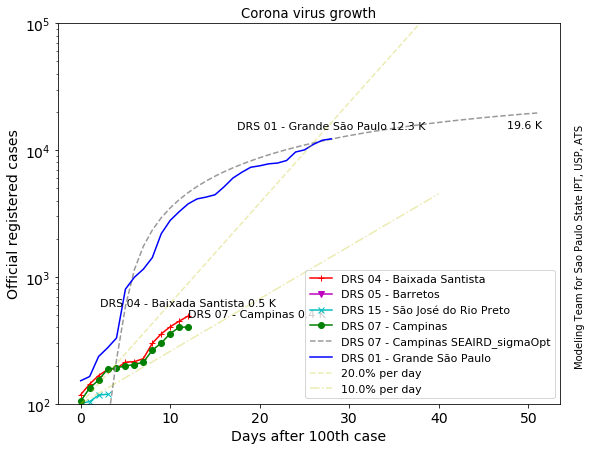

Infection speed= 5.9711479608590965
Day with the maximum infections occurred= 19
Total number of recorded infected people at the infection’s end= 14779
Errors =  [0.4871004084256057, 1.1389234118914553]


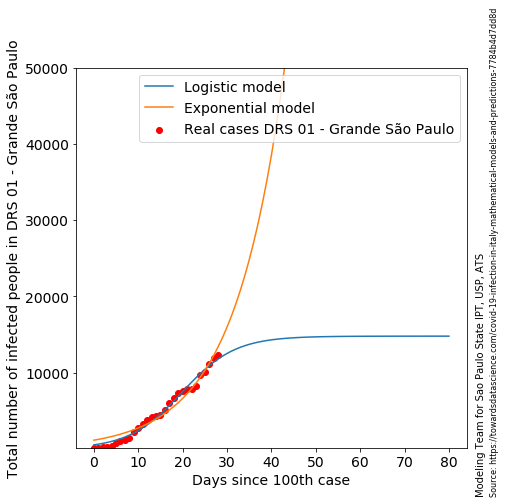

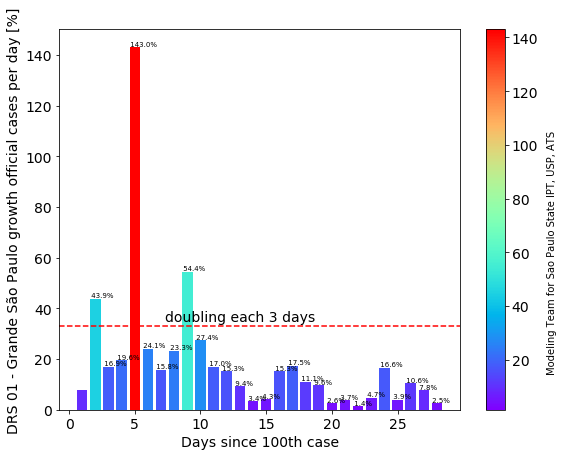

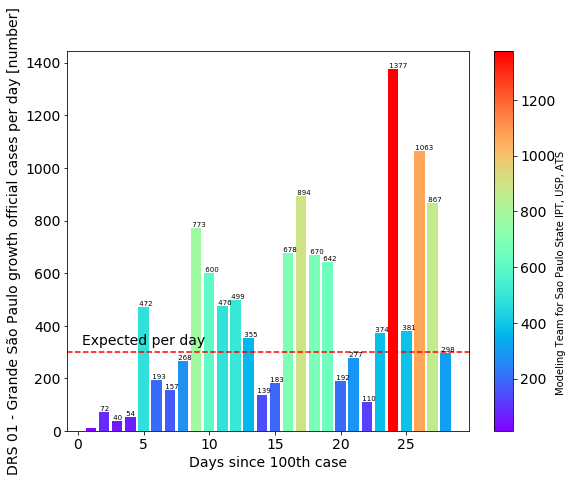

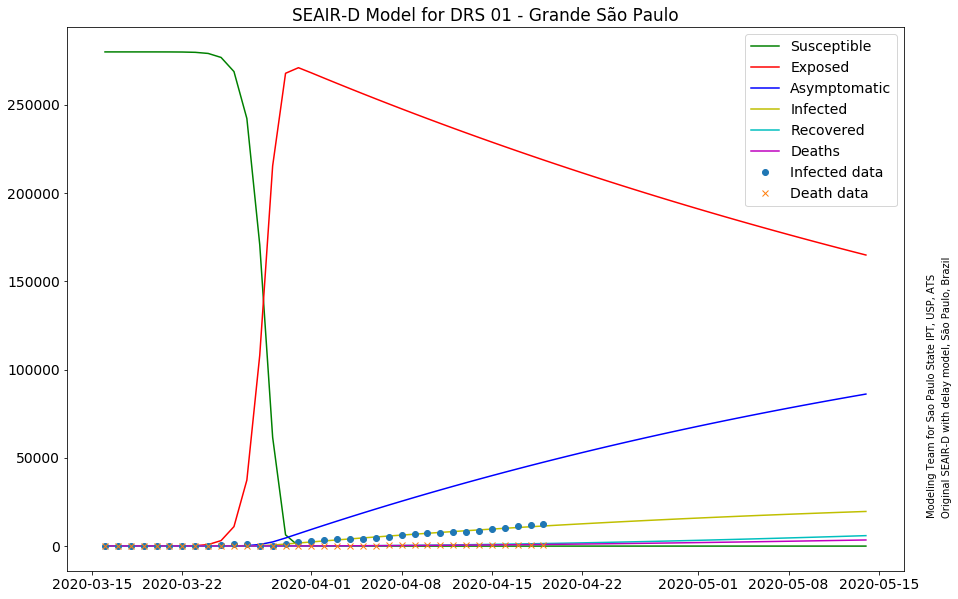

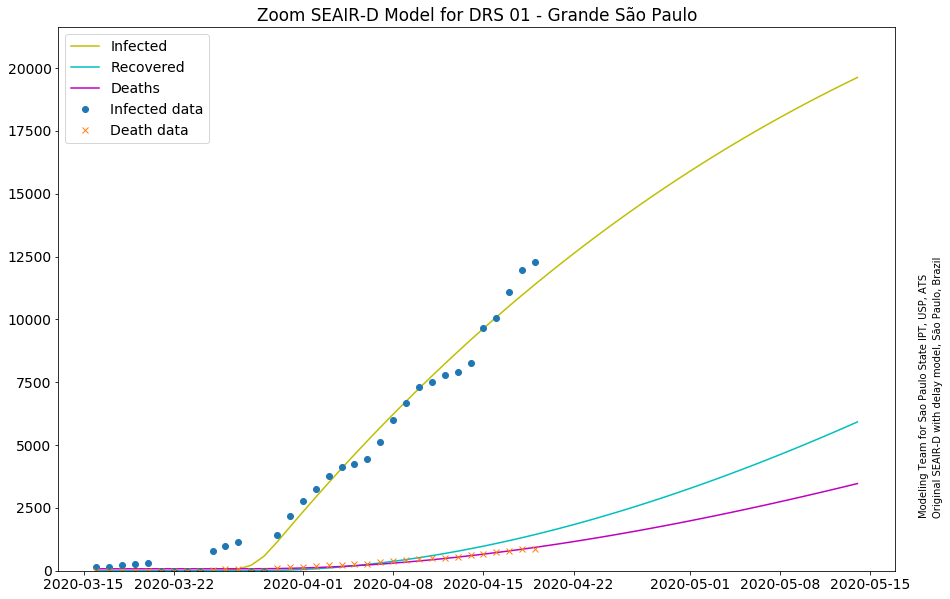

In [20]:
covid_plots.covid_plots(districtRegion, districts4Plot, startdate,predict_range, startCase, opt, version, show=True)